# Overview

This week's curriculum focuses in figuring out (and visualizing) what's special about a certain text (or collection of texts). We'll also learn about community detection in networks (that's how we'll get our groups of text)

* Tricks for raw text (NLPP, Chapter 3).
* Community Detection and info-boxes 
* Identifying important words in a document (TF-IDF)

In the first part, we will take a quick tour of NLPP1e's chapter 3, which is boring, super useful ressource. Then we'll talk about how we can use simple statistics & machine learning to get text to show us what it's all about. We will even do a little visualization. 

In the latter parts we will go back to network science, discussing community detection, mixing in some NLP, and trying it all out on our very own dataset.


# Part 1: Processing real text (from out on the inter-webs)

Ok. So Chapter 3 in NLPP is all about working with text from the real world. Getting text from this internet, cleaning it, tokenizing, modifying (e.g. stemming, converting to lower case, etc) to get the text in shape to work with the NLTK tools you've already learned about - and many more. 

In the process we'll learn more about regular expressions, as well as unicode; something we've already been struggling with a little bit will now be explained in more detail. 

<div class="alert alert-block alert-info">
One of the things that the LLMs have changed is how we don't have to suffer over regular expressions as much as in the old days. As I talk about in the video, regular expressions used to be a big, painful part of working with text. Nowadays, we can simply ask an LLM to help construct them ... and it tends to work really well. And regular expressions are not really important to know about - you need to know they exist so you can used them, but the details are not worth remembering. So this is one area where you can use LLMs as much as you like without a guilty conscience. (But remember to check and test the results thoroughly! The LLMs might still make mistakes.)
</div>

> 
> **Video lecture**: Short overview of chapter 3 + a few words about kinds of language processing that we don't address in this class. 
> 

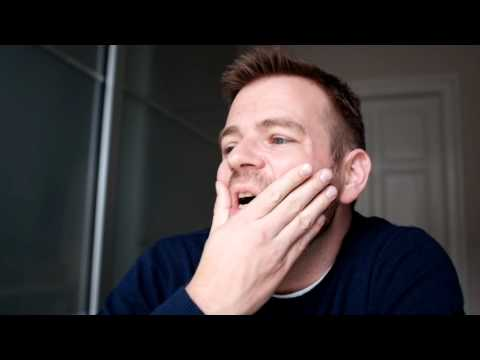

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

> *Reading*: NLPP Chapter 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.9, and 3.10\. It's not important that you go in depth with everything here - the key think is that you *know that Chapter 3 of this book exists*, and that it's a great place to return to if you're ever in need of an explanation of regular expressions, unicode, or other topics that you forget as soon as you stop using them (and don't worry, I forget about those things too).
> 

# Part 2: Community detection

Let's begin by watching a lecture to learn about communities. If you want all the details, I recommend you take a look at _Chapter 9_ in the _Network Science_ book ... but the video lecture below should be enough to get you started. 

**Note**: For this and the next exercise, work on the _undirected_ version of the network.

> **_Video Lecture_**: Communities in networks. 

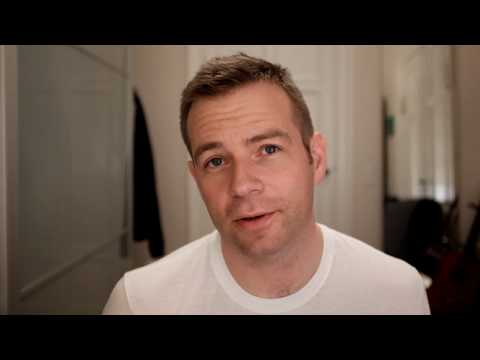

In [2]:
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

# direct youtube link: https://www.youtube.com/watch?v=FSRoqXw28RI

Before we get started on *network* communities, we'll grab some information on a different kind of communities based on information from Wikipedia. Specifically, the ``infoboxes``. An infobox is the little box usually displayed on the right when you open an artist's page. 

For example if you open the page for [The Rolling Stones](https://en.wikipedia.org/wiki/The_Rolling_Stones), you'll see that it contains info about their place of ***origin***, the ***genre***s of music they've been associated with (in the case of the Stones it's `rock`, `pop` and `blues`), their ***year's active***, the record ***labels*** they've signed with over time, etc. All really interesting information if we want to understand the network of artists.

So let's start with an exercise designed to give you a sense of how good the LLMs are at the whole text-parsing thing.

*Exercise*: Go nuts with an LLM and get all the genres for the nodes in your network
> * Yes, I'm serious. For this one I'd like you to fire up your most powerful thinking model you have access to and get it to write a script to extract genre for all nodes in your network. Some notes to help you
>   * If the node doesn't have an `infobox` (or if a node's infobox doesn't have a `genre` it it), just don't assign that node a genre and ignore it in the downstream analysis
>   * Remember to lowercase all genres, also consider simplifying things by mapping `rock'n'roll`, `rock & roll`, etc to a single genre. 
>   * Remember to test your algorithm well before emplying it, since you're not writing the code yourself, you need to work harder to prove to yourself that it's actually doing what you think it's doing. You should inspect the code to understand what it's actually doing and also test it on the strangest edge-cases you can find. (Can it handle, "The Animals", for example).
>   * The output should be a dictionary mapping artist names to lists of genres (since most artists have multiple genres listed).
> * Report the following stats
>   * The number of nodes for which you could find genres
>   * The average number of genres per node
>   * The total number of distinct genres
>   * A histogram showing artist counts for the top 15 genres

<div class="alert alert-block alert-info">
LLMs all the way for this one. 
</div>

> Get your artist list from the .pkl filenames

In [3]:
import os, os.path as op

DATA_DIR = "../Week_4/data/rock_performers"

all_paths = [op.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) if f.endswith(".pkl")]
artists = sorted({op.splitext(op.basename(p))[0].strip(" '\"") for p in all_paths})
len(artists), artists[:10]

(585,
 ['10_Years',
  '10_Years_(band)',
  '10cc',
  '311',
  '311_(band)',
  '3_Doors_Down',
  'ABBA',
  'AC_DC',
  'AFI',
  'AFI_(band)'])

> Minimal Wikipedia fetch (HTML) + infobox locate

In [4]:
import requests
from bs4 import BeautifulSoup

HEADERS = {"User-Agent": "genre-scraper/0.1 (academic use)"}

def fetch_html(title: str) -> BeautifulSoup | None:
    url = "https://en.wikipedia.org/wiki/" + requests.utils.quote(title.replace(" ", "_"))
    r = requests.get(url, headers=HEADERS, timeout=15)
    if r.status_code != 200: 
        return None
    return BeautifulSoup(r.text, "html.parser")

def get_infobox(soup: BeautifulSoup):
    if not soup: 
        return None
    return soup.select_one("table.infobox")

> Extract the “Genre/Genres” cell and split it

In [5]:
import re, html

def clean_text(s: str) -> str:
    s = html.unescape(s).replace("\xa0"," ")
    return re.sub(r"\s+", " ", s).strip()

def extract_genre_text(td) -> list[str]:
    if not td: 
        return []
    # Prefer list items if present
    items = [clean_text(li.get_text(" ", strip=True)) for li in td.find_all("li")]
    if items:
        chunks = items
    else:
        # Fallback: collect link/br-separated text
        pieces = []
        for el in td.find_all(["a","span","br"]):
            if el.name == "br":
                pieces.append(", ")
            else:
                pieces.append(el.get_text(" ", strip=True))
        chunks = ["".join(pieces)] if pieces else [clean_text(td.get_text(" ", strip=True))]
    # Split on commas, slashes, and “and”
    out = []
    for raw in chunks:
        s = re.sub(r"\s+and\s+", ",", raw, flags=re.I)
        parts = re.split(r"[,/]", s)
        out.extend([p.strip() for p in parts if p.strip()])
    return out

def find_genres_in_infobox(soup: BeautifulSoup) -> list[str]:
    box = get_infobox(soup)
    if not box: 
        return []
    for th in box.find_all("th"):
        label = clean_text(th.get_text(" ", strip=True)).lower()
        if label in ("genre", "genres"):
            td = th.find_next("td")
            return extract_genre_text(td)
    return []


> Normalize and dedupe genres (keep it simple but effective)

In [6]:
def normalize_genre(g: str) -> str:
    g = g.lower()
    g = g.replace("’", "'").replace("‘","'").replace("–","-").replace("—","-").replace("&amp;","&")
    g = re.sub(r"\([^)]*\)|\[[^\]]*\]", "", g)  # drop () and [] clarifications
    g = re.sub(r"^[\W_]+|[\W_]+$", "", g)       # strip edge punctuation
    g = re.sub(r"\s+", " ", g).strip()

    # Canonicalize frequent variants
    mapping = {
        "rock 'n' roll": "rock and roll",
        "rock n' roll": "rock and roll",
        "rock n roll": "rock and roll",
        "rock & roll": "rock and roll",
        "hip-hop": "hip hop",
        "hiphop": "hip hop",
        "r and b": "r&b",
        "rnb": "r&b",
        "rhythm and blues": "r&b",
        "electro-pop": "electropop",
    }
    g = mapping.get(g, g)
    g = re.sub(r"\s*&\s*", " and ", g)  # unify & → and (post-mapping)
    return g

def normalize_list(genres: list[str]) -> list[str]:
    seen, out = set(), []
    for g in (normalize_genre(x) for x in genres):
        if g and g not in seen:
            seen.add(g)
            out.append(g)
    return out


> A single function that gets genres for one artist

In [7]:
def get_genres_for_artist(artist: str) -> list[str]:
    soup = fetch_html(artist)
    raw = find_genres_in_infobox(soup)
    return normalize_list(raw)

In [8]:
test_artists = ["The Rolling Stones","The Animals","AC/DC","Motörhead","R.E.M.","Guns N' Roses"]
{a: get_genres_for_artist(a) for a in test_artists}

{'The Rolling Stones': ['rock', 'pop', 'blues'],
 'The Animals': ['blues rock',
  'r and b',
  'psychedelic rock',
  'progressive rock',
  'rock',
  'roll'],
 'AC/DC': ['hard rock', 'blues rock', 'rock', 'roll', 'heavy metal'],
 'Motörhead': ['heavy metal', 'hard rock', 'speed metal'],
 'R.E.M.': ['alternative rock',
  'jangle pop',
  'folk rock',
  'college rock',
  'post-punk'],
 "Guns N' Roses": ['hard rock', 'heavy metal']}

> Run it over your network (polite, no fancy caching)

In [9]:
import time

artist_to_genres = {}
for i, a in enumerate(artists, 1):
    try:
        genres = get_genres_for_artist(a)
    except Exception:
        genres = []
    artist_to_genres[a] = genres
    if i % 25 == 0: 
        print(f"{i}/{len(artists)} done")
    time.sleep(0.35)  # don’t hammer Wikipedia

sum(bool(v) for v in artist_to_genres.values()), list(artist_to_genres.items())[:3]

25/585 done
50/585 done
75/585 done
100/585 done
125/585 done
150/585 done
175/585 done
200/585 done
225/585 done
250/585 done
275/585 done
300/585 done
325/585 done
350/585 done
375/585 done
400/585 done
425/585 done
450/585 done
475/585 done
500/585 done
525/585 done
550/585 done
575/585 done


(494,
 [('10_Years', []),
  ('10_Years_(band)',
   ['alternative metal', 'progressive metal', 'post-grunge', 'nu metal']),
  ('10cc',
   ['art rock', 'art pop', 'progressive pop', 'soft rock', 'pop rock'])])

> * The number of nodes for which you could find genres
> * The average number of genres per node
> * The total number of distinct genres

In [10]:
from collections import Counter
import json

with_genre = {k:v for k,v in artist_to_genres.items() if v}
n_nodes = len(with_genre)
avg_genres = (sum(len(v) for v in with_genre.values()) / n_nodes) if n_nodes else 0.0

distinct = set()
for v in with_genre.values():
    distinct.update(v)
n_distinct = len(distinct)

print("Nodes with genres:", n_nodes)
print("Avg #genres per node:", round(avg_genres, 3))
print("Distinct genres:", n_distinct)

genre_counts = Counter()
for v in with_genre.values():
    genre_counts.update(v)

# Save mapping for downstream work
with open("artist_genres.json","w", encoding="utf-8") as f:
    json.dump(artist_to_genres, f, ensure_ascii=False, indent=2)

Nodes with genres: 494
Avg #genres per node: 3.974
Distinct genres: 214


> * A histogram showing artist counts for the top 15 genres

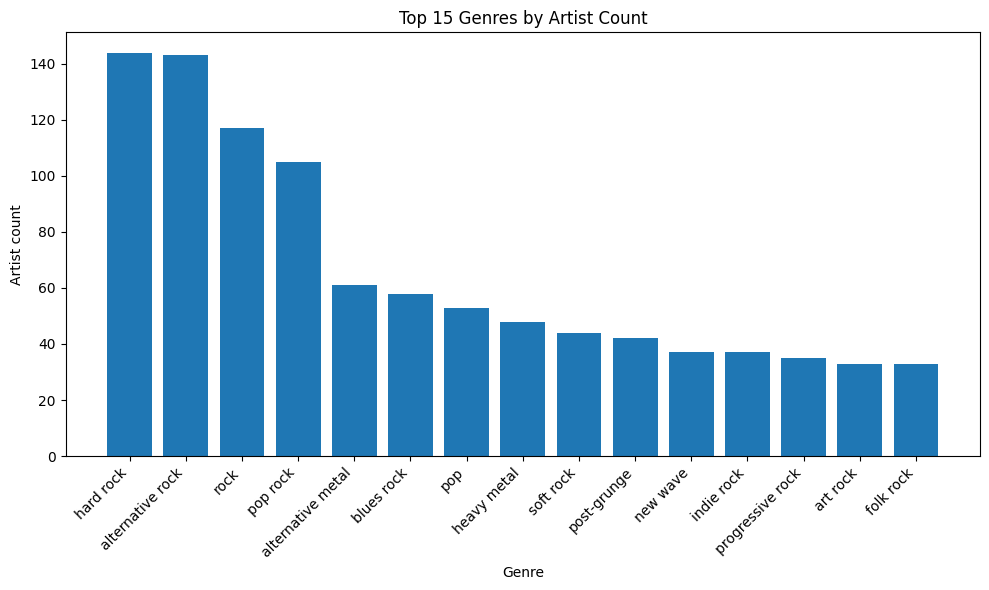

In [11]:
import matplotlib.pyplot as plt

top = genre_counts.most_common(15)
labels = [g for g, _ in top]
values = [c for _, c in top]

plt.figure(figsize=(10,6))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.xlabel("Genre")
plt.ylabel("Artist count")
plt.title("Top 15 Genres by Artist Count")
plt.tight_layout()
plt.show()

Now that we have the genres, let's use them - and see how community-like the community is, if we consider the genres to be community labels.


*Exercise*: Use the concept of modularity to explore how _community-like_ the genres are.
> 
> * Explain the concept of modularity in your own words.
> * Work from the undirected version of the network, keeping only the nodes for which you have genre information. 
> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity $M$ of the partition described above. Are the genres good communities?
> * Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre `rock` as their first genre in the list, so by definition the network won't have very high modularity.
>      * What happens to the modularity if you grab the first genre *that's not `rock`* as the genre-assignment for all nodes that have more than one genre?
>      * What happens to the modularity if you use a random genre from the list genre as the node-lable for those nodes with more than one genre listed?
> * Discuss your findings. 

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code here. But do write your own explanation of modularity, and do try to implement a modularity on your own from eq 9.12 in the book.
</div>

> * Explain the concept of modularity in your own words.

**Modularity** measures how well a network is divided into groups (communities).
It compares the actual number of edges *within* communities to the number expected if edges were randomly placed (while preserving node degrees).

Formally, if the network has adjacency matrix $A$, degree sequence $k_i$, total edges $m$, and community labels $c_i$:

$$
M = \frac{1}{2m} \sum_{i,j} \Big( A_{ij} - \frac{k_i k_j}{2m} \Big) \delta(c_i, c_j)
$$

* $A_{ij} = 1$ if there’s an edge between $i$ and $j$ ($0$ otherwise)
* $k_i = \text{degree of node} i$
* $2m = \sum_i k_i = \text{total number of edge-ends}$
* $\delta(c_i, c_j) = 1$ if nodes $i,j $ are in the same community (same genre), else $0$

Intuition:

* $A_{ij} \rarr$ how many edges *actually exist* inside a community
* $\frac{k_i k_j}{2m} \rarr$ how many *would exist by chance* in a null model (random wiring preserving degree)
* The difference shows whether the grouping captures more “within-group” edges than expected.

A **high modularity** (close to 1) → dense intra-community edges, few inter-community edges → strong communities.
A **low or negative modularity** → grouping doesn’t align with structure (bad partition).


> * Work from the undirected version of the network, keeping only the nodes for which you have genre information. 

In [12]:
import networkx as nx

G = nx.Graph()

for artist in artist_to_genres.keys():
    G.add_node(artist, genres=artist_to_genres[artist])

artists = list(artist_to_genres.keys())

for i in range(len(artists)):
    for j in range(i + 1, len(artists)):
        a1, a2 = artists[i], artists[j]
        # Find shared genres
        shared = set(artist_to_genres[a1]).intersection(artist_to_genres[a2])
        if shared:
            G.add_edge(a1, a2, weight=len(shared))

print(f"Undirected network created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Undirected network created with 585 nodes and 38496 edges


> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity $M$ of the partition described above. Are the genres good communities?

$$
M = \sum_{c=1}^{n_c} \left[ \frac{L_c}{L} - \left(\frac{k_c}{2L}\right)^2\right]
$$

Consider a network with $N$ nodes and $L$ links and a partition into nc communities, each community having $N_c$ nodes connected to each other by $L_c$ links, where $c=1, \ldots, n_c$. If $L_c$ is larger than the expected number of links between the $N_c$ nodes given the network’s degree sequence, then the nodes of the subgraph $C_c$ could indeed be part of a true community.

In [13]:
# Build genre_communities mapping (each node assigned the first genre in its list)
genre_communities = {}
for node in G.nodes():
    genres = artist_to_genres.get(node, [])
    if not genres:
        continue
    first_genre = genres[0]
    genre_communities.setdefault(first_genre, []).append(node)

In [14]:
# Now we use the formula:
L = G.number_of_edges()
if L == 0:
    print("Graph has no edges; modularity undefined.")
else:
    M = 0.0
    for genre, nodes in genre_communities.items():
        subG = G.subgraph(nodes)
        L_c = subG.number_of_edges()
        k_c = sum(dict(G.degree(nodes)).values())
        M += (L_c / L) - (k_c / (2 * L)) ** 2

    print(f"Calculated modularity (M): {M:.4f}")

Calculated modularity (M): 0.1140


> * Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre `rock` as their first genre in the list, so by definition the network won't have very high modularity.
>      * What happens to the modularity if you grab the first genre *that's not `rock`* as the genre-assignment for all nodes that have more than one genre?
>      * What happens to the modularity if you use a random genre from the list genre as the node-lable for those nodes with more than one genre listed?

> * Discuss your findings. 

*Exercise*: Community detection to find **structral communities** in the network
> * Again, work only with the subnetwork of nodes that have at least one genre.
> * Use [the Louvain-algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html) to find communities for the network. Report the value of modularity found by the algorithm. 
>     * **Note**: You can also try the *Infomap* algorithm instead if you're curious. Go to [this page]. (http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.
> * What is the modularity of this partitioning of the network? Is it more community-like than the genres? What does this comparison reveal about the communities?
> * Visualize the network, using the Force Atlas algorithm.
>     * This time assign each node a different color based on its structural _community_.
>     * **Note**: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
>     * Describe the structure you observe.
> * Keep using the community labels from above, but now visualize only the backbone-edges from your favorite network backbone from last week. Do the community correspond to the backbone structure you detected?

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here. 
</div>

Ok, now in this final community exercise, we want to check if the genres align with the communities.


> *Exercise*: Communities versus genres.
> * Compare the communities found by your algorithm with the music genres by creating a matrix $D$ with dimension ($G \times C$), where G is the 7 most common genres and C is the 7 most common communities. We set entry $D(i,j)$ to be the number of nodes that genre $i$ has in common with community $j$. The matrix $D$ is what we call a confusion matrix.
> * Use the confusion matrix to explain how well the communities you've detected correspond to the genres.
>     * **Note**: This time, use all the genres associate with each node
>     * **Note**: If a node is not characterized by any of the 7 most popular genres, just ignore it.
>     * **Note**: If a node is not part of by any of the 7 largest communiteis, just ignore it.

<div class="alert alert-block alert-info">
Again, you may use an LLM to help with the code for this assignment. The main thing is you get the D matrix right and interpret it.
</div>

# Part 3: Words that characterize pages or groups of pages

Now, we'll begin to play around with how far we can get with simple strategies for looking at text. 

The video is basically just me talking about a fun paper, which shows you how little is needed in order to reveal something highly interesting about humans that produce text. But it's important. Don't miss this one!

> **Video lecture**: Simple methods reveal a lot. I talk about the paper: [Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791).  

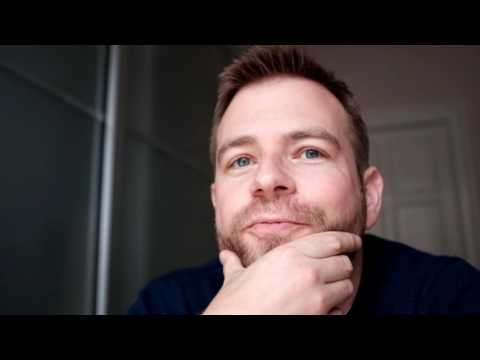

In [15]:
YouTubeVideo("wkYvdfkVmlI",width=800, height=450)

# direct youtube link: https://www.youtube.com/watch?v=wkYvdfkVmlI

_Exercise_: Comparing in the different genres. 

*Setup*. You'll need to go to your archives and find the wikipedia pages of all the rock artists. 

Once you have the texts ready, you will want to aggregate the text into 15 long lists, one for each of the top 15 genres (let's call them 15 *documents*). Each document contains on all the text in that genre (so for the rock genre it's a looooong big doc). In each list, you should keep all the words (or *tokens* to be more precise) that occur on the pages, and a count of how frequently each word occurs. So the format should be

```
word0 count0
word1 count1
word2 count2

...

wordN countN
```
This list is called a ***Term Frequency*** (or TF) list for each genre. Let's build our own TF lists. Before you start counting, I am going to ask you do do a few things

> *Action items*
> * Tokenize the pages into one long string per genre
> * Remove all punctuation from your list of tokens
> * Set everything to lower case
> * (Optional) Lemmatize your words
> * It's a good idea to filter out rare words (e.g. words that only appear less than 5 times).

If you are confused by the instructions for cleaning, go back and have a look at Chapter 3 again. You need to use the tools from the book to clean the text.

> *Action item*: 
> * Create your TF list for each of the 15 most popular genres.
> * List the top 15 words for each genre.
> * Comment on the top 15 words for each genre.

**Note**: Above you (once again) have to deal with the fact that many artists have multiple genres listed. Pick the method you like the best to deal with this. Some possible choices
* Counting each page multiple times, so a page counts once per genre that's listed
* Picking the first genre listed
* Picking the second genre listed
* Picking a random genre
* (... any other heuristic you like, e.g. using an api to ask an LLM to pick the genre that best describes the page from its list)

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here, but write your own comments.
</div>

# Part 4: Visualization

**Step 1: Install the software**

First you must set up your system. The most difficult thing about creating the wordcloud is installing the `WordCloud` module. It's available on GitHub, check out the page [**here**](https://github.com/amueller/word_cloud). 

You should be able to simply install using conda (and all dependencies, etc will be automatically fixed): 

    conda install -c conda-forge wordcloud
 
If you can't get that to work, there is more info on the GitHub page
 * On my system, the module needed the `gcc` compiler installed. If you're not already a programmer, you may have to install that. On Mac you get it by installing the [_command line tools_](http://osxdaily.com/2014/02/12/install-command-line-tools-mac-os-x/). On linux, it's probably already installed. And on Windows I'm not sure, but we'll figure it out during the exercises. 
 * Once that's all set up, you can use `pip` to install the `WordCloud` library, as [detailed on the GitHub page](https://github.com/amueller/word_cloud). But don't forget to use Anaconda's `pip`.
 * There are examples of how to use the module online, see [this page](http://sebastianraschka.com/Articles/2014_twitter_wordcloud.html) for a nice example. If you're interested, you can read about how the package was put together - and how it works [here](http://peekaboo-vision.blogspot.dk/2012/11/a-wordcloud-in-python.html). 

**Step 2: Draw some wordclouds**

> *Action items*
> * Get your lists ready for the word-cloud software
>    - The package needs a single string to work on. The way that I converted my lists to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its count. 
>    - The `wordcloud` package looks for collocations in real texts, which is a problem when you make the list as above. The recommended fix is to simply set `collocations = False` as an option when you run the package.
> * Now, create a word-cloud for each genre. Feel free to make it as fancy or non-fancy as you like. Comment on the results. (If you'd like, you can remove stopwords and wiki-syntax - I did a bit of that for my own wordclouds.)

<div class="alert alert-block alert-info">
As above, it's OK to use an LLM to help get the code going. But write your own answers to the questions.
</div>

# Part 5: Understanding TF-IDF

Now we jump back into the NLP work. In this last part, we'll be creating word-clouds again. But this time, we'll be using the method from the paper I discuss above: TF-IDF. Historically people have had a hard time grasping the idea behind TF-IDF, so here's a little exercise designed to make you study it a bit more carefully.

*Exercise 4*: Wrap your brain around TF-IDF

First, let's learn about TF-IDF the way wikipedia explains it. Check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and ***read the first part very carefully***. The idea is that the term frequency doesn't capture just what's special about a text. It also only captures words that are just frequent in all text. 

This is clear from the top counts in one of my lists:

```
of 
in 
and 
the 
to 
a 
is
by
was
as
ref
with
first
 ```
 
You can fix some of this by removing stop-words (as is described in the book), but it's not enough. ***We want to pull out what's special about a particular text.*** 

To focus on just what's special, TF-IDF has two components: The *term frequency* (TF) and a *weight* (IDF). The weight draws on a larger corpus of text emphasize what's special about the text we're interested in.

Further, there are some extra things going on. For example, there are multiple definitions of TF on wikipedia. Above, we just looked at the raw counts.

> *Action item*
>   * Pick one of the alternative term frequency definitions. Explain why it might sometimes be prefereable to the raw count.

Now, let's talk about the inverse document frequency.

> *Action item*
>   * What does IDF stand for? Answer in your own words.
>   * How does IDF draw on a larger corpus to extract what's special a certain text? Answer in your own words.

There are also multiple versions of IDF. Let's think about those for a moment.

> *Action items*
>   * All of the IDF versions take the log of the calculated weight. Why do you think that is?
>   * Explain why using IDF makes stopword removal less important.

<div class="alert alert-block alert-info">
The point of this exercise is to understand TF-IDF. So if there are parts of the wikipedia page you don't understand, I encourage you to ask questions to an LLM to really understand the concept. Perhaps ask it to explain TF-IDF at the level of a high-school student. Once you've done that, then answer the questions in the action items on your own.
</div>

# Part 6: Genres and TF-IDF word-clouds

**But wait a minute!** Now we have all of the ingredients for a wonderful cocktail 😎

* We have genres - descriptions of related nodes in the network. 
* And you're an expert on TF-IDF, so you can extract words that characterize a text relative to everything that's going on.
* Finally, you can create nice WordCouds!

So let's put it all together. Let's use TF-IDF and wordcoulds to build a deeper understanding of the top communities.

Thus, the aim of this final part is to create genre wordclouds for the top 15 genres based on TF-IDF. 

For each genre, create a single document for each community consisting of all the cleaned text from all members of the community. So in the end, you should have 15 documents in total.

_Exercise_: Genre Word-clouds

> * Now that we have the community-texts, let's start by grabbing the TF lists from the exercise above (you may modify to use whichever version of TF you like). 
> * Next, calculate IDF for every word in every list (use whichever version of IDF you like). 
>   * Which base logarithm did you use? Is that important?
> * We're now ready to calculate TF-IDFs. Do that for each genre. 
>   * List the 10 top words for each genre accourding to TF-IDF. Are these 10 words more descriptive of the genre than just the TF? Justify your answer.
> * Create a wordcloud for each genre.
>     * **Note**: you may have to rescale the TF-IDF weights so they make sense to the wordcloud package. Write about this issue and how you solve it.
> * Explain your creation. Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code. But do write your own answers to the questions.
</div>

*Exercise*: Community Word-clouds
> * Redo the exercise above but for the 15 largest structural communities.
> * Do the word clouds seem more meaningful than for the genres? Optional: Add nuance to your answer by considering the confusion matrix $D$ that you calculated above.

Note that this is a great way of characterizing the structural communities if you don't have genre-labels (or other labels for that matter).

<div class="alert alert-block alert-info">
Todays exercices are getting, long and involved so you can do whatever parts of this one that you like with LLMs. Maybe you can even get one to solve the whole exercise?
</div>